In [2]:
%run -i ../functions/load_packages.ipynb
%run -i ../functions/helper_functions.ipynb

### Setup network files and relevant technologies for 2030

In [3]:
res_techs = [
        "csp",
        "rooftop-solar",
        "solar",
        "onwind",
        "onwind2",
        "offwind",
        "offwind2",
        "ror",
    ]

res_tech = [
        "solar"
    ]
   
scen_dict = {'Optimistic 2030':{
                      'run': 'MT_opt30', 'cluster': '30', 'ir': '0.076', 'ds':'NZ'
                  },
              'Realistic 2030':{
                      'run': 'MT_real30', 'cluster': '31', 'ir': '0.082', 'ds':'AP'
              },
            'Conservative 2030':{
                      'run': 'MT_con30', 'cluster': '32', 'ir': '0.097', 'ds':'AP'
            },
}

Q30 = [
        "1",
        "5",
        "10",
        "100",
        "200"
    ]
timestep = "3"

### Technology share

In [7]:

def tech_share(n):
    tech = ["solar", "onwind", "ror", "oil", "coal"]
    for t in tech:
        tech_cap = n.generators.loc[n.generators.carrier == t].p_nom.sum()
        print("{} technology share: {} MW ( {} % )".format((t, tech_cap, tech_cap/tech_cap.sum())*1e2))

#n30 elec network
n_30 = pypsa.Network("../../sandbox-cs/pypsa-earth-sec/pypsa-earth/networks/elec_s_30_ec_lc1.0_Co2L_opt.nc")
tech_share(n_30)

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_opt.nc has buses, carriers, generators, global_constraints, lines, loads


solar technology share: 144.6177089159373 MW ( 27.19557908475117 % )
onwind technology share: 4.72570354166636 MW ( 0.8886757048072215 % )
ror technology share: 213.7791478246421 MW ( 40.201492368512156 % )
oil technology share: 58.01418868337344 MW ( 10.909656004116714 % )
coal technology share: 110.63243478758092 MW ( 20.804596837812745 % )


### Additional renewable for export quantity

In [8]:
def calc_additional_res(n, n_ref, tech):
    res_index = n.generators.filter(regex='{}$'.format(tech), axis=0).index

    res_cap = n.generators.p_nom_opt[res_index].sum()
    res_cap_ref = n_ref.generators.p_nom_opt[res_index].sum()

    return (res_cap - res_cap_ref) / 1e3

### Additional electrolyser for export quantity

In [9]:
def calc_additional_elec(n, n_ref):

    elec_cap = n.links.filter(like='Electrolysis', axis=0).p_nom_opt.sum()
    res_cap_ref = n_ref.links.filter(like='Electrolysis', axis=0).p_nom_opt.sum()

    return (elec_cap - res_cap_ref) / 1e3

### Utilization for export quantity

In [10]:
def calc_util(n, tech):
    
    tech_index = n.generators.loc[n.generators.carrier == tech].index

    weightings = pd.DataFrame(
        np.outer(n.snapshot_weightings["generators"], [1.0] * len(tech_index)),
        index=n.snapshots,
        columns=tech_index,
    )
    gen_tech = (n.generators_t.p.filter(regex='{}$'.format(tech)) * weightings).sum()
    installed_cap = n.generators.p_nom_opt.filter(regex='{}$'.format(tech))
    year_avail = (n.generators_t.p_max_pu.filter(regex='{}$'.format(tech)) * weightings ).sum()
    
    max_gen_solar=(installed_cap * year_avail)
    
    return (gen_tech/max_gen_solar).mean()  
    

### electrolyser capacity utilized

In [11]:
def calc_elec_capa(n):

    elec_cap = n.links.filter(like='Electrolysis', axis=0).p_nom_opt.sum() *8760
    elec_output = n.links_t.p0.filter(like='Electrolysis').sum().sum() * float(timestep)

    return elec_output / elec_cap

### electrolyser capacity utilized at export location

In [12]:
def calc_elec_capa_exp(n):

    export_buses = n.links.loc[n.links.bus1 == 'H2 export bus', 'bus0'] + ' Electrolysis'

    elec_cap = n.links.loc[export_buses].p_nom_opt.sum() *8760
    elec_output = n.links_t.p0[export_buses].sum().sum() *  float(timestep)

    return elec_output / elec_cap
 

In [13]:

df = pd.DataFrame()
for q in Q30:
    for pathway in scen_dict.keys():
        li = []
        scenario = scen_dict[pathway]
        n_ref = pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
        n = pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_{}export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"], q))
        
        #Additional renewable for export quantities
        for tech in res_techs:
            li.append(calc_additional_res(n, n_ref, tech))
        
        #Additional electrolyzer for export quantities
        li.append(calc_additional_elec(n, n_ref))

        dftemp = pd.DataFrame(li)
        dftemp.index = ['Additional CSP [GW]','Additional Rooftop Solar [GW]','Additional Solar [GW]','Additional Onshore wind [GW]','Additional Onshore wind-2 [GW]','Additional Offshore Wind [GW]','Additional Offshore Wind-2 [GW]','Additional Hydro[GW]','Additional Electrolyser[GW]]']
        dftemp.columns=["{} [{} TWh]".format(pathway, q)]
        df = pd.concat([df, dftemp], axis=1)   
df

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_31_ec_lc1.0_Co2L_3H_2030_0.082_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_31_ec_lc1.0_Co2L_3H_2030_0.082_AP_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_32_ec_lc1.0_Co2L_3H_2030_0.097_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_32_ec_lc1.0_Co2L_3H_2030_0.097_AP_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Im

,Optimistic 2030 [1 TWh],Realistic 2030 [1 TWh],Conservative 2030 [1 TWh],Optimistic 2030 [5 TWh],Realistic 2030 [5 TWh],Conservative 2030 [5 TWh],Optimistic 2030 [10 TWh],Realistic 2030 [10 TWh],Conservative 2030 [10 TWh],Optimistic 2030 [100 TWh],Realistic 2030 [100 TWh],Conservative 2030 [100 TWh],Optimistic 2030 [200 TWh],Realistic 2030 [200 TWh],Conservative 2030 [200 TWh]
Additional CSP [GW],0.000200,0.000227,-0.000071,-1.380614e-05,0.000164,-0.000121,0.000295,-4.311455e-06,-0.000119,0.000288,0.000148,0.000224,-0.000009,0.000226,-0.000030
Additional Rooftop Solar [GW],0.000305,0.000274,-0.000132,-7.628998e-07,0.000226,-0.000269,0.000286,-3.092759e-08,-0.000281,0.000188,0.000211,0.000017,-0.000009,0.000272,-0.000179
Additional Solar [GW],0.910759,0.924035,0.912764,4.321386e+00,4.349025,4.217589,8.657846,8.599472e+00,8.564317,87.970949,87.022794,87.502301,175.439014,174.156674,175.118503
Additional Onshore wind [GW],0.001937,-0.104457,-0.107318,-5.649958e-05,-0.144334,-0.112696,0.001473,-1.453334e-01,-0.112701,0.001148,-0.144410,-0.111323,-0.000233,-0.143921,-0.112323
Additional Onshore wind-2 [GW],0.000776,0.000796,-0.000248,-4.138601e-05,0.000540,-0.000399,0.000947,-3.168376e-05,-0.000399,0.000874,0.000351,0.000376,-0.000061,0.000703,-0.000203
Additional Offshore Wind [GW],0.000156,0.000175,-0.000046,-4.496498e-06,0.000129,-0.000072,0.000187,-5.106712e-06,-0.000074,0.000176,0.000087,0.000105,-0.000007,0.000153,-0.000024
Additional Offshore Wind-2 [GW],0.000125,0.000133,-0.000046,-2.960897e-06,0.000097,-0.000071,0.000142,-3.894921e-06,-0.000073,0.000132,0.000074,0.000068,-0.000006,0.000113,-0.000031
Additional Hydro[GW],0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Additional Electrolyser[GW]],0.577449,0.619428,0.612128,2.574883e+00,2.512028,2.444391,5.113817,5.075456e+00,5.035436,51.363240,51.805268,51.275910,102.969676,103.614828,102.578481


INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_5export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:I

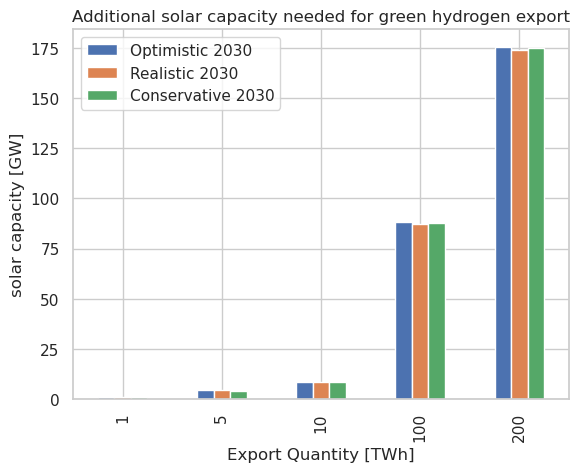

In [14]:
df = pd.DataFrame()
for tech in res_tech:
    for pathway in scen_dict.keys():
        li = []
        qi = []
        for q in Q30:
            qi.append(q)
            scenario = scen_dict[pathway]
            n_ref = pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
            n = pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_{}export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"], q))
            
            #Additional renewable for export quantities
        
            li.append(calc_additional_res(n, n_ref, tech))
            
            #Additional electrolyzer for export quantities
            #li.append(calc_additional_elec(n, n_ref))

        dftemp = pd.DataFrame([li])
        dftemp.index = [pathway]
        dftemp.columns=qi
        #dftemp.columns=["{} [{} TWh]".format(pathway, q)]
        df = pd.concat([df, dftemp])
    df=df.T
    # # print(df.index.unique())
    # df.columns = ["Optimistic 2030", "y"]
    # df=df.set_index("y")
    df.plot(kind="bar", legend=True, xlabel="Export Quantity [TWh]", ylabel="{} capacity [GW]".format(tech), title = "Additional {} capacity needed for green hydrogen export".format(tech) )
#df

### Additional electrolyzer capacity

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_5export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:I

<AxesSubplot:title={'center':'Additional Electrolyzer capacity needed for green hydrogen export'}, xlabel='Export Quantity [TWh]', ylabel='Electrolyzer capacity [GW]'>

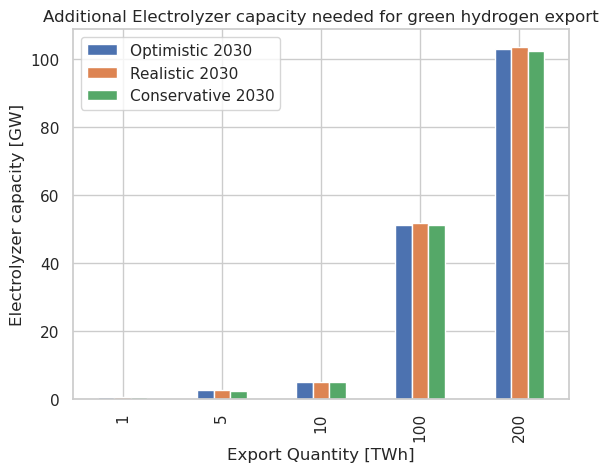

In [15]:

df = pd.DataFrame()
for pathway in scen_dict.keys():
    li = []
    qi = []
    for q in Q30:
        qi.append(q)
        scenario = scen_dict[pathway]
        n_ref = pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
        n = pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_{}export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"], q))
        
        #Additional renewable for export quantities
    
        li.append(calc_additional_elec(n, n_ref))
        
        #Additional electrolyzer for export quantities
        #li.append(calc_additional_elec(n, n_ref))

    dftemp = pd.DataFrame([li])
    dftemp.index = [pathway]
    dftemp.columns=qi
    #dftemp.columns=["{} [{} TWh]".format(pathway, q)]
    df = pd.concat([df, dftemp])
df=df.T
# # print(df.index.unique())
# df.columns = ["Optimistic 2030", "y"]
# df=df.set_index("y")
df.plot(kind="bar", legend=True, xlabel="Export Quantity [TWh]", ylabel="Electrolyzer capacity [GW]".format(tech), title = "Additional Electrolyzer capacity needed for green hydrogen export".format(tech) )
#df

In [16]:
df = pd.DataFrame()
#df.index = ['CSP Utilisation [%]','Rooftop-solar Utilisation [%]','Solar Utilisation [%]','Onshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Offshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Hydro Utilisation [%]','Electrolyser Utilisation [%]','Electrolyser Utilisation at export node [%]']
for q in Q30:
    for pathway in scen_dict.keys():
        li = []
        scenario = scen_dict[pathway]
        n_ref = pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_0export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"]))
        n = pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_{}export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"], q))
        
        #Additional renewable for export quantities
        for tech in res_techs:
            li.append(calc_util(n, tech)*1e2)
        
        #Additional electrolyzer for export quantities
        li.append(calc_elec_capa(n)*1e2)
        li.append(calc_elec_capa_exp(n)*1e2)
        dftemp = pd.DataFrame(li)
        dftemp.index = ['CSP Utilisation [%]','Rooftop-solar Utilisation [%]','Solar Utilisation [%]','Onshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Offshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Hydro Utilisation [%]','Electrolyser Utilisation [%]','Electrolyser Utilisation at export node [%]']
        dftemp.columns=["[{} TWh]".format(q)]
        df = pd.concat([df, dftemp], axis=1)   
dfplot = df.copy()
df

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_31_ec_lc1.0_Co2L_3H_2030_0.082_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_31_ec_lc1.0_Co2L_3H_2030_0.082_AP_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_32_ec_lc1.0_Co2L_3H_2030_0.097_AP_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_32_ec_lc1.0_Co2L_3H_2030_0.097_AP_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Im

,[1 TWh],[1 TWh],[1 TWh],[5 TWh],[5 TWh],[5 TWh],[10 TWh],[10 TWh],[10 TWh],[100 TWh],[100 TWh],[100 TWh],[200 TWh],[200 TWh],[200 TWh]
CSP Utilisation [%],60.110271,66.748272,64.238493,62.163717,64.424175,64.433246,64.726144,61.438400,62.198637,57.730242,65.283962,61.869661,60.562267,59.918838,64.921938
Rooftop-solar Utilisation [%],58.270103,59.058650,59.787941,62.073191,59.889102,60.491787,58.742153,60.992701,56.600965,54.030207,58.924659,55.881227,55.206744,57.692374,57.615450
Solar Utilisation [%],77.016326,74.181796,67.756482,79.797873,75.656276,75.578178,78.696614,68.941457,70.682822,79.066645,66.259996,69.013285,70.889031,70.608602,68.471781
Onshore wind Utilisation [%],74.503608,77.654746,78.002379,76.497693,74.718825,73.879840,72.380947,76.617778,72.637334,67.136640,73.655162,69.488669,68.103455,71.883437,71.243036
Onshore wind-2 Utilisation [%],66.383562,68.404400,69.723065,68.737150,66.957856,66.255765,66.102774,68.811719,65.626987,61.403654,66.478990,62.572120,61.119623,64.551446,64.202832
Offshore wind Utilisation [%],62.117121,64.821246,62.607997,65.839805,64.399360,64.254037,63.637490,63.786849,64.047241,61.360516,63.456918,62.961518,59.110079,61.172298,61.743812
Onshore wind-2 Utilisation [%],57.763714,59.849452,58.103981,61.041486,59.254678,59.754392,58.530460,59.140553,59.697226,56.081967,58.312513,58.752054,54.903933,56.706949,58.635557
Hydro Utilisation [%],inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
Electrolyser Utilisation [%],33.986629,33.389246,33.503547,33.815940,34.515853,35.195010,33.565114,33.672695,33.903796,32.783498,32.576214,32.846700,32.656868,32.553113,32.821050
Electrolyser Utilisation at export node [%],39.797525,28.068691,28.690172,42.721131,34.874287,35.715031,41.712263,33.718913,33.978884,29.004491,32.538833,32.812192,31.241739,32.533585,32.795541


### Scenario based renewable energy utilization (%)


INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_5export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_100export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_200export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_31_ec_lc1.0_Co2L_3H_2030_0.082_AP_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.

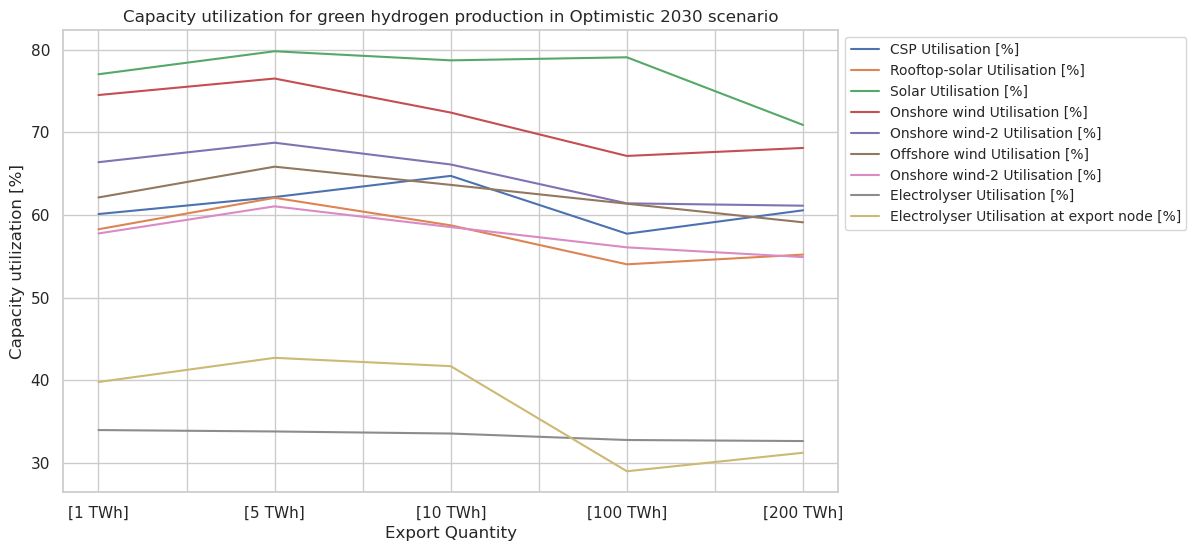

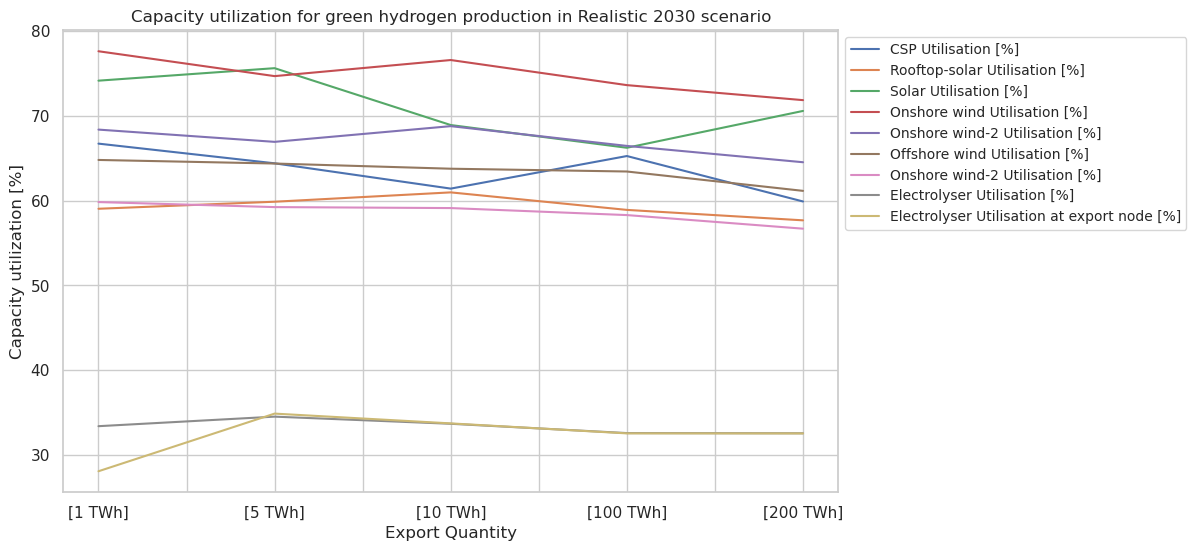

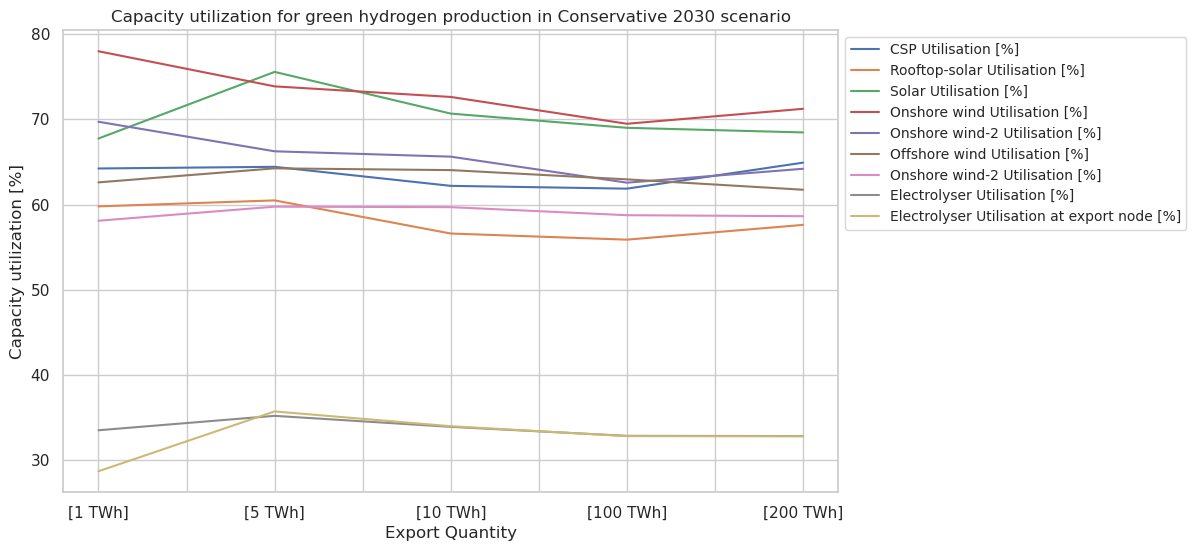

In [17]:
#df = pd.DataFrame()
#df.index = ['CSP Utilisation [%]','Rooftop-solar Utilisation [%]','Solar Utilisation [%]','Onshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Offshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Hydro Utilisation [%]','Electrolyser Utilisation [%]','Electrolyser Utilisation at export node [%]']

for pathway in scen_dict.keys():
    df = pd.DataFrame()
    for q in Q30:
        li = []
        scenario = scen_dict[pathway]
        n = pypsa.Network("/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_{}H_2030_{}_{}_{}export.nc".format(scenario["run"], scenario["cluster"], timestep, scenario["ir"], scenario["ds"], q))
        
        #Additional renewable for export quantities
        for tech in res_techs:
            li.append(calc_util(n, tech)*1e2)
        
        #Additional electrolyzer for export quantities
        li.append(calc_elec_capa(n)*1e2)
        li.append(calc_elec_capa_exp(n)*1e2)
        dftemp = pd.DataFrame(li)
        dftemp.index = ['CSP Utilisation [%]','Rooftop-solar Utilisation [%]','Solar Utilisation [%]','Onshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Offshore wind Utilisation [%]','Onshore wind-2 Utilisation [%]','Hydro Utilisation [%]','Electrolyser Utilisation [%]','Electrolyser Utilisation at export node [%]']
        dftemp.columns=["[{} TWh]".format(q)]
        df = pd.concat([df, dftemp], axis=1) 
    
    dfplot = df.copy()
    dfplot=dfplot.drop("Hydro Utilisation [%]")
    #ax = plt.gca()
    dfplot.T.plot(kind="line",legend=True, xlabel="Export Quantity", ylabel="Capacity utilization [%]", 
        title = "Capacity utilization for green hydrogen production in {} scenario".format(pathway), figsize = (10,6)).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
)
    
#df

### Normalized cost of hydrogen at export location

(1.0, 3.5)

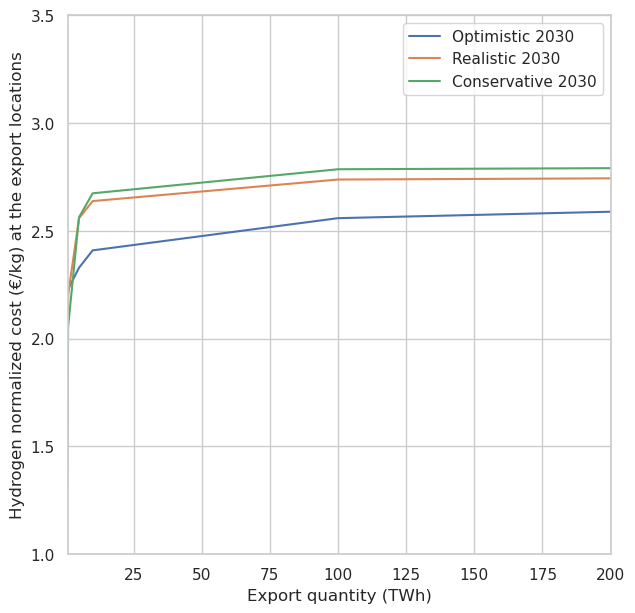

In [18]:
# create figure and axis
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)

li = []
for pathway in scen_dict.keys():
    scenario = scen_dict[pathway]
    metrics_opt30 = "/home/raj08555/dev/sandbox-cs/pypsa-earth-sec/results/{}/csvs/metrics.csv".format(scenario["run"])
    df = pd.read_csv(metrics_opt30, keep_default_na=False,
            na_values=[""])
    df=df.set_index('cluster')
    df = df.loc[['export', 'total costs']]
    df = df.apply(pd.to_numeric)

    dfc = [0]
    for column in df.columns[1:]:
        dfc.append((df.loc["total costs",column].astype(float)- df.loc["total costs", "{}".format(scenario["cluster"])].astype(float)) / (df.loc["export", column] * (1e+09/33.33)))
    dfc = pd.DataFrame(dfc).transpose()
    dfc.columns = ["{}".format(scenario["cluster"]), "{}.1".format(scenario["cluster"]), "{}.2".format(scenario["cluster"]), "{}.3".format(scenario["cluster"]), "{}.4".format(scenario["cluster"]), "{}.5".format(scenario["cluster"])]
    dfopt = pd.concat([df, dfc], axis=0)
    dfopt.T.plot(ax=ax, x='export', y=0, grid=True)
    li.append(pathway)

ax.legend(li);
#ax.legend(["Realistic 2030", "Conservative 2030"]);
ax.set_ylabel('Hydrogen normalized cost (€/kg) at the export locations',fontsize=12)
ax.set_xlabel('Export quantity (TWh)',fontsize=12)
ax.set_xlim(1,200)
ax.set_ylim(1,3.5)